In [2]:
from Evaluator import Evaluator
from Predictor import Predictor
import numpy as np
import os

/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
db_path = "/scratch/users/mdelabrassinne/Database/SoccerDB.db"
model = None
size = 2
tresholds = np.array([0.5, 0.01, 0.001, 0.9999, 0.5, 0])
min_count = 1
fps = 2
type_pred = "Validation"
actions_name = ['Corner', 'Goal', 'Penalty', 'Kick-off', 'card', 'NoClass']

predictor = Predictor(size, model, db_path, tresholds=tresholds, min_count = min_count, fps=fps, actions = actions_name)
preds = predictor.load_predictions()
real_preds = []
for pred in preds:
    if pred:
        real_preds.append(pred)
preds = real_preds
evals = []
for pred in preds:
    timeline = predictor.predict_match(pred)
    evals.append({"Match": pred["Match"], "Timeline": timeline})

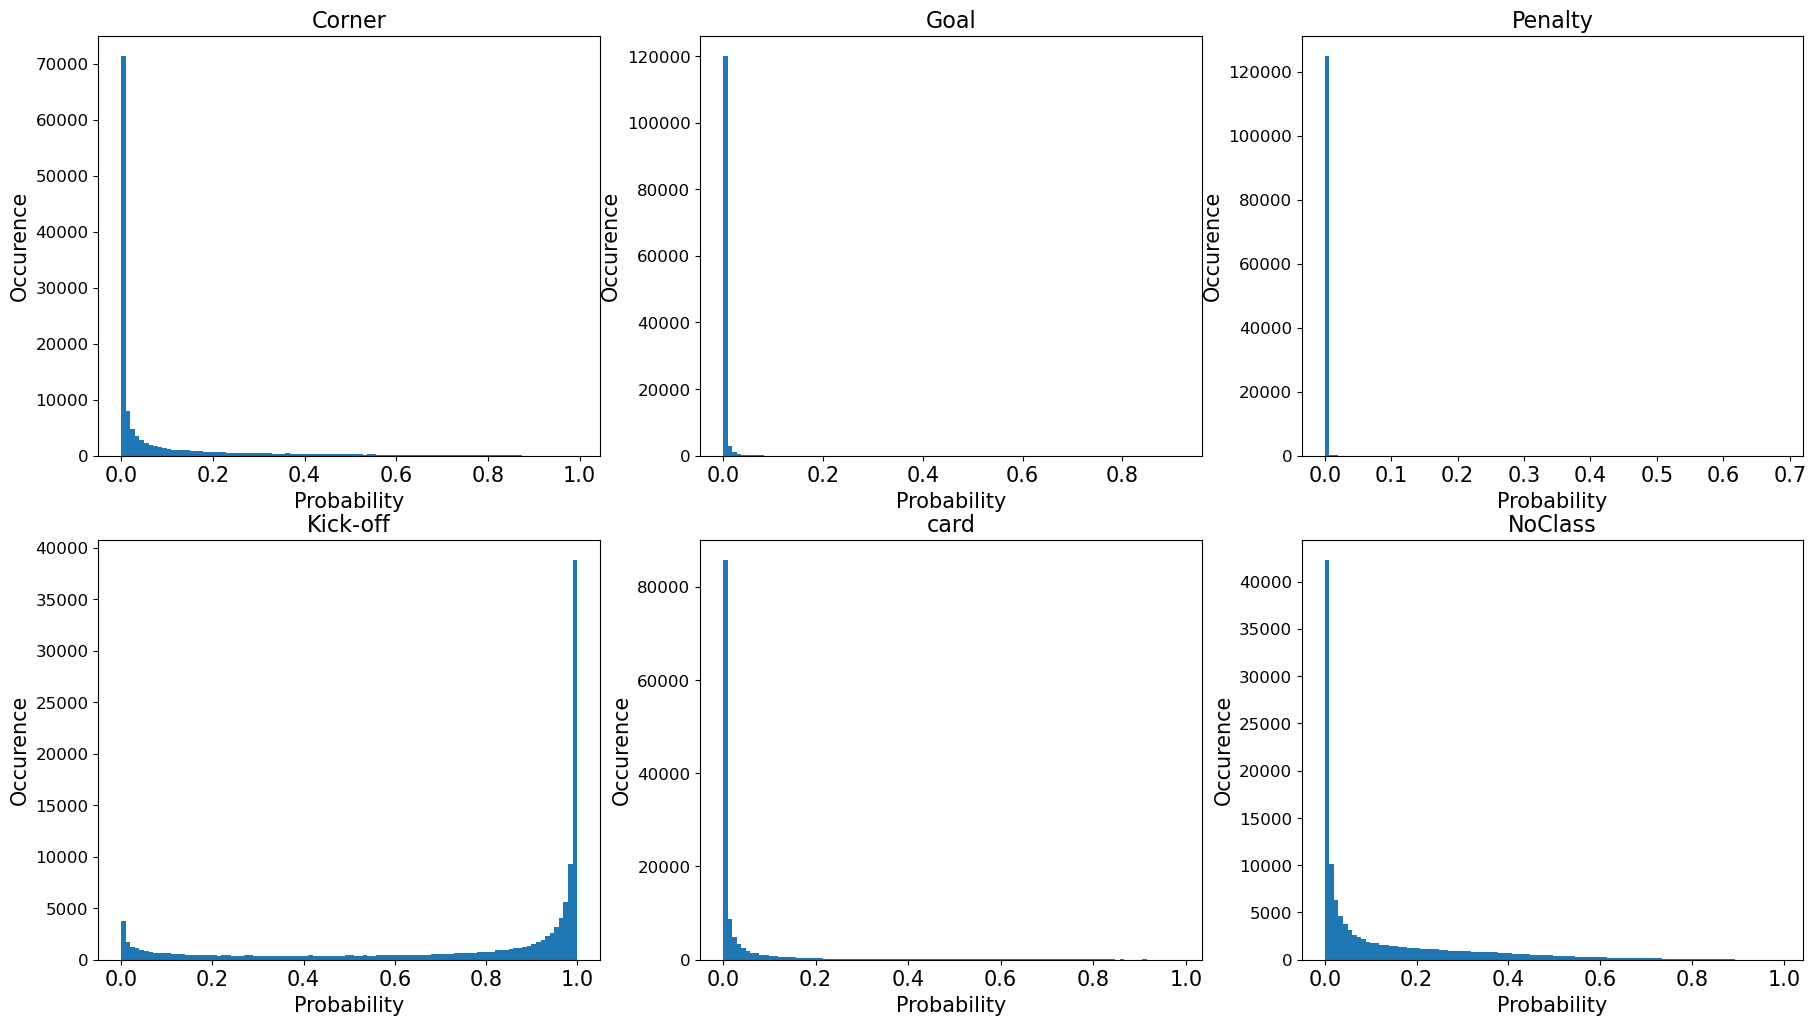

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(22, 12))

data = np.array(preds[0]["Prediction"])
time_data = np.array(preds[0]["Time"])

for i, pred in enumerate(preds):
    if i != 0:
        predictions = pred["Prediction"]
        time = pred["Time"]
        # add predictions to data
        data = np.concatenate((data, predictions), axis=0)
        time_data = np.concatenate((time_data, time), axis=0)

for i, eval in enumerate(actions_name):
    if i < 3:
        ax[0, i].hist(data[:, i], bins=100)
        ax[0, i].set_title(eval, fontsize =16)
        ax[0, i].set_xlabel("Probability", fontsize =15)
        ax[0, i].set_ylabel("Occurence", fontsize =15)
        ax[0, i].tick_params(axis ='x', labelsize=15)
        ax[0, i].tick_params(axis ='y', labelsize=12)
    else:
        ax[1, i-3].hist(data[:, i], bins=100)
        ax[1, i-3].set_title(eval, fontsize =16)
        ax[1, i-3].set_xlabel("Probability", fontsize =15)
        ax[1, i-3].set_ylabel("Occurence", fontsize =15)
        ax[1, i-3].tick_params(axis ='x', labelsize=15)
        ax[1, i-3].tick_params(axis ='y', labelsize=12)

plt.savefig("hist_pred.pdf")
plt.show()

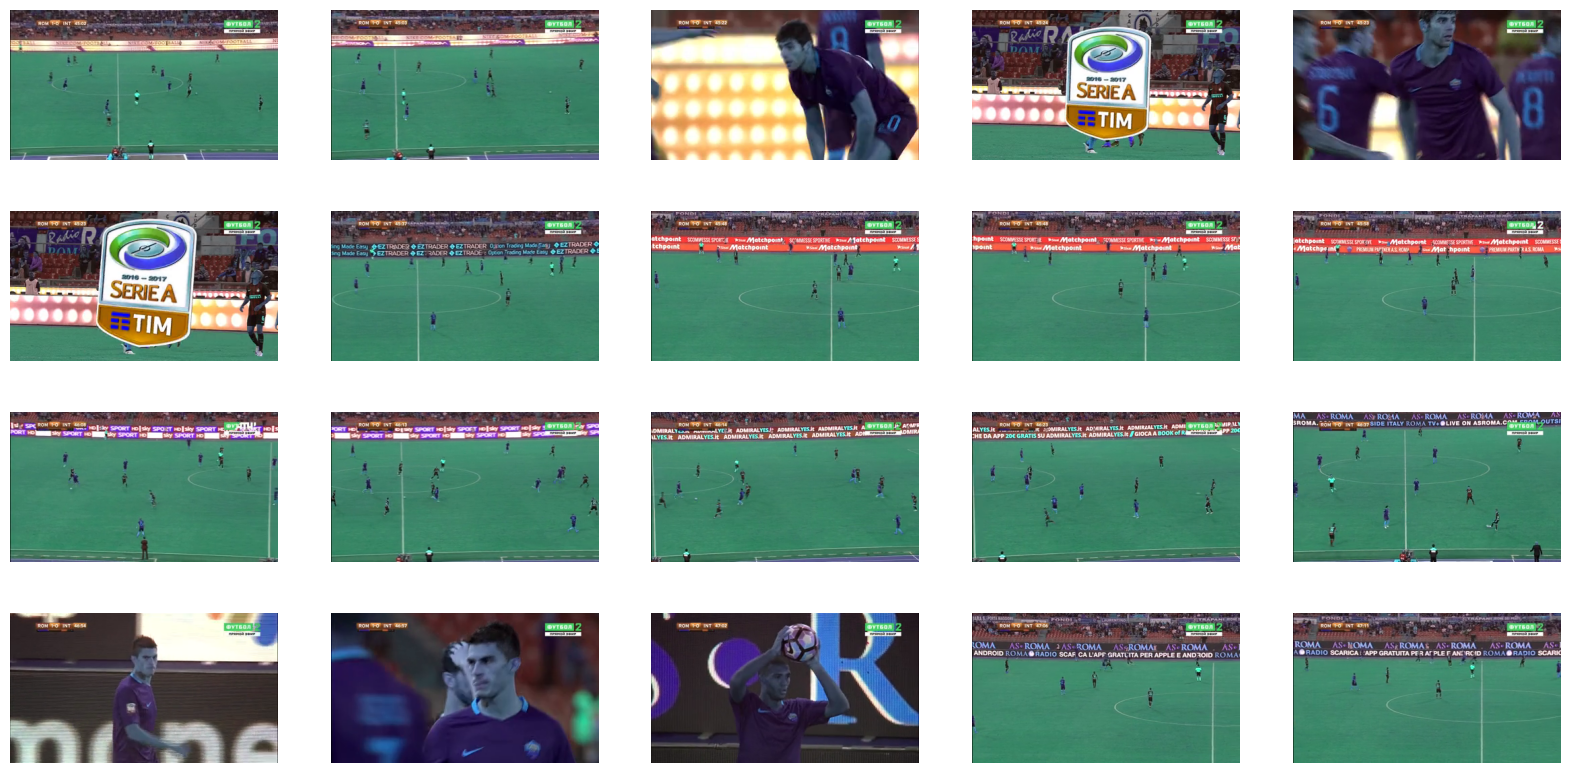

In [10]:
import matplotlib.pyplot as plt
import cv2

data = np.array(preds[0]["Prediction"])
time_data = np.array(preds[0]["Time"])

examples = 0
images = []
p_min = 0.8
p_max = 0.9
val = 3

i = 0

while (i < len(preds)):
    if i == 0:
        pred = preds[i]
        predictions = np.array(pred["Prediction"])
        time = pred["Time"]
        # add predictions to data
        #data = np.concatenate((data, predictions), axis=0)
        #time_data = np.concatenate((time_data, time), axis=0)

        mkv_path = pred["Match"]
        fps = 2
        fps_file = 25
        for j in range(predictions.shape[0]):
            if predictions[j, val] > p_min and predictions[j, val] < p_max: # Kick-off
                examples += 1
                # Take image from mkv file "mkv_path"
                frame = round(j * fps_file / fps)
                # Get image
                cap = cv2.VideoCapture(mkv_path)
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
                ret, image = cap.read()
                images.append(image)
                j += 1000
        
            if examples >= 20:
                break
        
        if examples >= 20:
                break
        i += 1
        
# show images:
fig, ax = plt.subplots(4, 5, figsize=(20, 10))
for i, image in enumerate(images):
    ax[i//5, i%5].imshow(image)
    ax[i//5, i%5].axis("off")

plt.savefig(f"im_{p_min}_{p_max}.pdf")
plt.show()


        

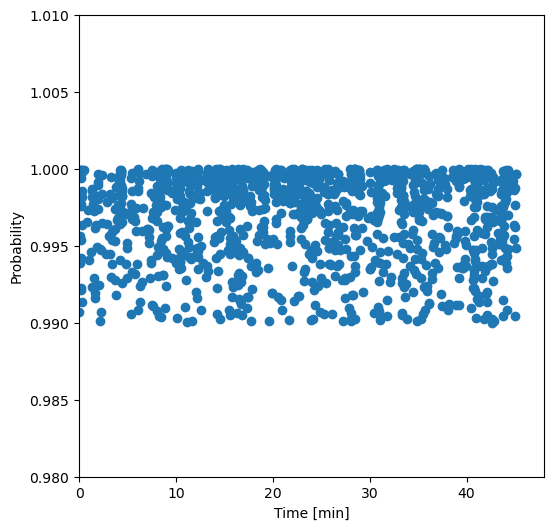

In [11]:
predictions = preds[0]["Prediction"]
time = preds[0]["Time"]
pred = np.array(predictions)
p_min = 0.99
val = 3

pred_y = []
time_y = []
for i in range(pred.shape[0]):
    if pred[i, val] > p_min:
        pred_y.append(pred[i, val])
        time_y.append(time[i] / (1000 * 60))


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(time_y, pred_y)
ax.set_ylim(0.98, 1.01)
ax.set_xlim(0, 48)
ax.set_ylabel("Probability")
ax.set_xlabel("Time [min]")

plt.savefig("proba_match_k_o.pdf")
plt.show()

In [7]:
pred_files = []
sol_files = []
for eval in evals:
    eval["json_pred"] = Evaluator.create_json(eval["Match"], eval["Timeline"], type_pred)
    eval["json_sol"] = Evaluator.get_json_sol(eval["Match"])
    # if sol does not exist, remove eval from evals
    if os.path.exists(eval["json_sol"]):
        # remove eval from evals
        pred_files.append(eval["json_pred"])
        sol_files.append(eval["json_sol"])
    else:
        print("No solution for match: " + eval["Match"])

In [8]:
#pred_files = zip(pred_files)
#sol_files = zip(sol_files)
res = Evaluator.get_mAP(pred_files, sol_files)

100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


In [5]:
res

{'mAP_classes': {'Penalty': 0.0,
  'Kick-off': 0.0,
  'Goal': 0.0,
  'Corner': 0.0,
  'Yellow card': 0.0},
 'mAP': 0.0}